In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,  Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader
pd.set_option("display.max_rows",200)


In [2]:
def plot(prediction,target,grey=None,start=None,end=None):
    
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # else:
    #     ylim = (df.min(),df.max())
    

    if not isinstance(prediction,pd.DataFrame):
        Results=pd.DataFrame(prediction,index=target.index)
        Results.plot(ax=ax,legend=True)
        ylim = (Results.min().min(),Results.max().max())
    else:
        prediction.plot(ax=ax,legend=True)
        ylim = (0,1)
    ax.fill_between(target.index, 0, ylim[1]+1e-2, target,facecolor='k', alpha=0.1)
    ax.axvline(x='2022-02-24', color='r')
    if not isinstance(prediction,pd.DataFrame):
        legend_list=["Prediction", "NBER recession indicator"]
    else:
        legend_list=["Prediction",'lower','upper', "NBER recession indicator"]
    if '2022-02-24' in target.index:
        legend_list+=['Russian invasion of Ukraine']
    ax.legend(legend_list)
        
    return fig,ax

In [3]:
fixed_data=0

In [4]:
%store -r fixed_data


In [6]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
# df=fixed_data

recessions =  DataReader('USRECDM', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-250)

df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1971':] #.resample('MS').last()
print(df.shape)
df.head()

(629, 126)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,in a recession,target
1971-01-01,0.008594,0.009600,0.013628,0.009750,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,NaN,0.001843,0.010833,-0.011895,-0.011013,NaN,-0.14,0.031962,0,0.0
1971-02-01,0.001962,0.001020,0.001887,0.005569,NaN,-0.001908,0.000877,-0.001373,-0.000561,0.022391,...,NaN,0.001179,0.010407,0.004643,-0.013202,NaN,-0.14,0.032042,0,0.0
1971-03-01,0.003127,0.002768,0.000489,0.004140,NaN,-0.001085,-0.002941,-0.001829,0.002849,0.001160,...,NaN,0.000532,0.001600,0.000542,0.003094,NaN,-0.09,0.019583,0,0.0
1971-04-01,0.002685,0.002760,0.005983,0.005425,NaN,0.005601,0.005047,0.003638,0.008156,0.006448,...,NaN,-0.000702,0.007395,0.006602,0.001663,NaN,-0.10,0.027399,0,0.0
1971-05-01,0.003806,0.004074,-0.000729,0.004872,NaN,0.005062,0.000738,-0.000040,0.000866,0.015415,...,NaN,0.001328,-0.003425,-0.000199,-0.025178,NaN,0.03,-0.020088,0,0.0


<Axes: >

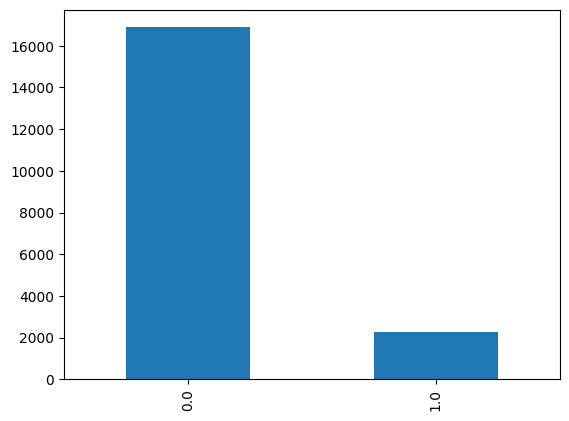

In [23]:
df.target.value_counts().plot.bar()

In [24]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)

In [81]:
df_for_training=df[:"2004"]
df_for_testing=df["2004":]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_testing shape: ',df_for_testing.shape)

# Scalling

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))

print()
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
trainX.shape,trainY.shape

df_for_training shape:  (12419, 126)
df_for_testing shape:  (7091, 126)



((12389, 30, 125), (12389, 1))

# with recessions 

In [121]:
def CustomLoss(labels, pred,w=0.2): 
    logits=tf.math.log(pred/(1-pred))
    return tf.nn.weighted_cross_entropy_with_logits(labels, logits, w)

In [122]:
from tensorflow.keras.layers import LSTM,  Dense, Dropout, Conv1D, MaxPool1D,Flatten,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

PT_path='Model/CNN2-LSTM-test'
f1 = EarlyStopping(monitor='recall', mode='max', verbose=1, patience=30)
f2 = ModelCheckpoint(filepath=PT_path, monitor='recall', mode='max', verbose=0, save_best_only=True)



In [123]:

model = Sequential()
model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),))
model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
# model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
model.add(MaxPool1D(1))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(100, return_sequences=False))
model.add(Dense((n_forecast)
            ,activation='sigmoid'
            ))
model.summary()
# fit the model
model.compile(optimizer='adam',
              metrics=['Recall','Precision',"AUC"],
              loss=CustomLoss
            # loss='BinaryCrossentropy'
              )
# fit the model
history = model.fit(trainX, trainY, epochs=250, batch_size=320, 
                    validation_split=0.1, 
                    verbose=1,  
                    callbacks=[
                                #  f1,
                                f2
                               ]
                  )


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 28, 32)            12032     
                                                                 
 conv1d_25 (Conv1D)          (None, 26, 32)            3104      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 26, 32)           0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 26, 32)            0         
                                                                 
 flatten_12 (Flatten)        (None, 832)               0         
                                                                 
 repeat_vector_12 (RepeatVec  (None, 1, 832)           0         
 tor)                                                

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 16s 335ms/step - loss: 0.1633 - recall: 0.0273 - precision: 0.1406 - auc: 0.5186 - val_loss: 0.0307 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/250
35/35 [==============================] - 2s 69ms/step - loss: 0.1261 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.6916 - val_loss: 0.0266 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/250
35/35 [==============================] - 3s 76ms/step - loss: 0.1111 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.8210 - val_loss: 0.0064 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 4/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0959 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.8865 - val_loss: 0.0030 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 5/250
35/35 [==============================] - 3s 83ms/step - loss: 0.0901 -

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 11s 316ms/step - loss: 0.0755 - recall: 0.0576 - precision: 1.0000 - auc: 0.9424 - val_loss: 6.6992e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 12/250
35/35 [==============================] - ETA: 0s - loss: 0.0727 - recall: 0.1117 - precision: 0.9946 - auc: 0.9481

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 270ms/step - loss: 0.0727 - recall: 0.1117 - precision: 0.9946 - auc: 0.9481 - val_loss: 5.0688e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 13/250
35/35 [==============================] - ETA: 0s - loss: 0.0701 - recall: 0.1383 - precision: 0.9913 - auc: 0.9538

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 17s 485ms/step - loss: 0.0701 - recall: 0.1383 - precision: 0.9913 - auc: 0.9538 - val_loss: 6.2725e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 14/250
35/35 [==============================] - ETA: 0s - loss: 0.0652 - recall: 0.1930 - precision: 0.9969 - auc: 0.9638

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 13s 369ms/step - loss: 0.0652 - recall: 0.1930 - precision: 0.9969 - auc: 0.9638 - val_loss: 3.7246e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 15/250
35/35 [==============================] - ETA: 0s - loss: 0.0629 - recall: 0.2603 - precision: 0.9977 - auc: 0.9656

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 12s 353ms/step - loss: 0.0629 - recall: 0.2603 - precision: 0.9977 - auc: 0.9656 - val_loss: 1.6590e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 16/250
35/35 [==============================] - ETA: 0s - loss: 0.0628 - recall: 0.3240 - precision: 0.9656 - auc: 0.9660

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 11s 331ms/step - loss: 0.0628 - recall: 0.3240 - precision: 0.9656 - auc: 0.9660 - val_loss: 1.4480e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 17/250
35/35 [==============================] - ETA: 0s - loss: 0.0624 - recall: 0.3362 - precision: 0.9668 - auc: 0.9659

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 12s 348ms/step - loss: 0.0624 - recall: 0.3362 - precision: 0.9668 - auc: 0.9659 - val_loss: 1.1266e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 18/250
35/35 [==============================] - ETA: 0s - loss: 0.0573 - recall: 0.3865 - precision: 0.9907 - auc: 0.9718

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 13s 389ms/step - loss: 0.0573 - recall: 0.3865 - precision: 0.9907 - auc: 0.9718 - val_loss: 5.3249e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 19/250
35/35 [==============================] - ETA: 0s - loss: 0.0562 - recall: 0.4181 - precision: 0.9843 - auc: 0.9711

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 17s 501ms/step - loss: 0.0562 - recall: 0.4181 - precision: 0.9843 - auc: 0.9711 - val_loss: 4.1842e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 20/250
35/35 [==============================] - ETA: 0s - loss: 0.0531 - recall: 0.4612 - precision: 0.9769 - auc: 0.9768

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 11s 317ms/step - loss: 0.0531 - recall: 0.4612 - precision: 0.9769 - auc: 0.9768 - val_loss: 2.9511e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 21/250
35/35 [==============================] - ETA: 0s - loss: 0.0549 - recall: 0.4788 - precision: 0.9393 - auc: 0.9747

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 15s 448ms/step - loss: 0.0549 - recall: 0.4788 - precision: 0.9393 - auc: 0.9747 - val_loss: 2.1483e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 22/250
35/35 [==============================] - 3s 73ms/step - loss: 0.0557 - recall: 0.4515 - precision: 0.9713 - auc: 0.9709 - val_loss: 2.0751e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 23/250
35/35 [==============================] - ETA: 0s - loss: 0.0491 - recall: 0.5231 - precision: 0.9740 - auc: 0.9787

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 16s 456ms/step - loss: 0.0491 - recall: 0.5231 - precision: 0.9740 - auc: 0.9787 - val_loss: 1.7873e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 24/250
35/35 [==============================] - ETA: 0s - loss: 0.0462 - recall: 0.5431 - precision: 0.9760 - auc: 0.9823

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 22s 655ms/step - loss: 0.0462 - recall: 0.5431 - precision: 0.9760 - auc: 0.9823 - val_loss: 1.5741e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 25/250
35/35 [==============================] - 3s 84ms/step - loss: 0.0473 - recall: 0.5394 - precision: 0.9769 - auc: 0.9799 - val_loss: 1.6934e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 26/250
35/35 [==============================] - ETA: 0s - loss: 0.0428 - recall: 0.5643 - precision: 0.9810 - auc: 0.9856

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 14s 403ms/step - loss: 0.0428 - recall: 0.5643 - precision: 0.9810 - auc: 0.9856 - val_loss: 1.4432e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 27/250
35/35 [==============================] - ETA: 0s - loss: 0.0386 - recall: 0.6292 - precision: 0.9867 - auc: 0.9880

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 21s 615ms/step - loss: 0.0386 - recall: 0.6292 - precision: 0.9867 - auc: 0.9880 - val_loss: 1.2400e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 28/250
35/35 [==============================] - 3s 88ms/step - loss: 0.0390 - recall: 0.6141 - precision: 0.9778 - auc: 0.9886 - val_loss: 9.5367e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 29/250
35/35 [==============================] - 3s 91ms/step - loss: 0.0386 - recall: 0.6189 - precision: 0.9808 - auc: 0.9877 - val_loss: 9.5367e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 30/250
35/35 [==============================] - ETA: 0s - loss: 0.0376 - recall: 0.6450 - precision: 0.9770 - auc: 0.9886

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 14s 403ms/step - loss: 0.0376 - recall: 0.6450 - precision: 0.9770 - auc: 0.9886 - val_loss: 9.5367e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 31/250
35/35 [==============================] - ETA: 0s - loss: 0.0351 - recall: 0.6644 - precision: 0.9821 - auc: 0.9900

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 16s 480ms/step - loss: 0.0351 - recall: 0.6644 - precision: 0.9821 - auc: 0.9900 - val_loss: 9.5367e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 32/250
35/35 [==============================] - 3s 72ms/step - loss: 0.0366 - recall: 0.6523 - precision: 0.9720 - auc: 0.9880 - val_loss: 9.5367e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 33/250
35/35 [==============================] - 2s 70ms/step - loss: 0.0388 - recall: 0.6286 - precision: 0.9728 - auc: 0.9866 - val_loss: 9.5367e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 34/250
35/35 [==============================] - 3s 72ms/step - loss: 0.0360 - recall: 0.6450 - precision: 0.9717 - auc: 0.9895 - val_loss: 9.5367e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 35/250
35/35 [==============================] - 3s 98ms/step - loss: 0.0340 - rec

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 11s 333ms/step - loss: 0.0302 - recall: 0.6899 - precision: 0.9853 - auc: 0.9931 - val_loss: 8.6362e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 38/250
35/35 [==============================] - ETA: 0s - loss: 0.0322 - recall: 0.6960 - precision: 0.9820 - auc: 0.9896

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 27s 782ms/step - loss: 0.0322 - recall: 0.6960 - precision: 0.9820 - auc: 0.9896 - val_loss: 3.5407e-08 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 39/250
35/35 [==============================] - 5s 141ms/step - loss: 0.0333 - recall: 0.6742 - precision: 0.9849 - auc: 0.9896 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 40/250
35/35 [==============================] - 5s 140ms/step - loss: 0.0328 - recall: 0.6650 - precision: 0.9786 - auc: 0.9909 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 41/250
35/35 [==============================] - 5s 138ms/step - loss: 0.0356 - recall: 0.6377 - precision: 0.9731 - auc: 0.9891 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 42/250
35/35 [==============================] - ETA: 0s - loss: 0.0269 - recal

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 31s 903ms/step - loss: 0.0269 - recall: 0.7124 - precision: 0.9866 - auc: 0.9952 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 43/250
35/35 [==============================] - ETA: 0s - loss: 0.0278 - recall: 0.7154 - precision: 0.9858 - auc: 0.9927

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 29s 839ms/step - loss: 0.0278 - recall: 0.7154 - precision: 0.9858 - auc: 0.9927 - val_loss: 4.6952e-08 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 44/250
35/35 [==============================] - 5s 150ms/step - loss: 0.0288 - recall: 0.7002 - precision: 0.9838 - auc: 0.9930 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 45/250
35/35 [==============================] - 5s 135ms/step - loss: 0.0294 - recall: 0.6960 - precision: 0.9854 - auc: 0.9920 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 46/250
35/35 [==============================] - ETA: 0s - loss: 0.0240 - recall: 0.7282 - precision: 0.9893 - auc: 0.9958

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 26s 772ms/step - loss: 0.0240 - recall: 0.7282 - precision: 0.9893 - auc: 0.9958 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 47/250
35/35 [==============================] - ETA: 0s - loss: 0.0236 - recall: 0.7397 - precision: 0.9870 - auc: 0.9956

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 31s 903ms/step - loss: 0.0236 - recall: 0.7397 - precision: 0.9870 - auc: 0.9956 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 48/250
35/35 [==============================] - ETA: 0s - loss: 0.0229 - recall: 0.7409 - precision: 0.9903 - auc: 0.9951

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 32s 945ms/step - loss: 0.0229 - recall: 0.7409 - precision: 0.9903 - auc: 0.9951 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 49/250
35/35 [==============================] - ETA: 0s - loss: 0.0207 - recall: 0.7725 - precision: 0.9861 - auc: 0.9973

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 33s 975ms/step - loss: 0.0207 - recall: 0.7725 - precision: 0.9861 - auc: 0.9973 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 50/250
35/35 [==============================] - 6s 176ms/step - loss: 0.0218 - recall: 0.7712 - precision: 0.9891 - auc: 0.9962 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 51/250
35/35 [==============================] - 6s 183ms/step - loss: 0.0242 - recall: 0.7451 - precision: 0.9856 - auc: 0.9951 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 52/250
35/35 [==============================] - 6s 179ms/step - loss: 0.0324 - recall: 0.7093 - precision: 0.9766 - auc: 0.9881 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 53/250
35/35 [==============================] - 6s 168ms/step - loss: 0.0237 -

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 39s 1s/step - loss: 0.0209 - recall: 0.7761 - precision: 0.9869 - auc: 0.9967 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 55/250
35/35 [==============================] - 6s 162ms/step - loss: 0.0299 - recall: 0.7221 - precision: 0.9810 - auc: 0.9868 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 56/250
35/35 [==============================] - 6s 172ms/step - loss: 0.0306 - recall: 0.7015 - precision: 0.9755 - auc: 0.9908 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 57/250
35/35 [==============================] - ETA: 0s - loss: 0.0203 - recall: 0.8064 - precision: 0.9852 - auc: 0.9970

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 35s 1s/step - loss: 0.0203 - recall: 0.8064 - precision: 0.9852 - auc: 0.9970 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 58/250
35/35 [==============================] - ETA: 0s - loss: 0.0183 - recall: 0.8155 - precision: 0.9882 - auc: 0.9978

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 34s 996ms/step - loss: 0.0183 - recall: 0.8155 - precision: 0.9882 - auc: 0.9978 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 59/250
35/35 [==============================] - ETA: 0s - loss: 0.0178 - recall: 0.8325 - precision: 0.9856 - auc: 0.9979

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 36s 1s/step - loss: 0.0178 - recall: 0.8325 - precision: 0.9856 - auc: 0.9979 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 60/250
35/35 [==============================] - ETA: 0s - loss: 0.0150 - recall: 0.8592 - precision: 0.9930 - auc: 0.9987

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 33s 966ms/step - loss: 0.0150 - recall: 0.8592 - precision: 0.9930 - auc: 0.9987 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 61/250
35/35 [==============================] - 6s 162ms/step - loss: 0.0174 - recall: 0.8447 - precision: 0.9858 - auc: 0.9980 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 62/250
35/35 [==============================] - 6s 162ms/step - loss: 0.0173 - recall: 0.8398 - precision: 0.9900 - auc: 0.9979 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 63/250
35/35 [==============================] - 5s 151ms/step - loss: 0.0155 - recall: 0.8483 - precision: 0.9929 - auc: 0.9984 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 64/250
35/35 [==============================] - 5s 143ms/step - loss: 0.0238 -

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 34s 1000ms/step - loss: 0.0135 - recall: 0.8744 - precision: 0.9938 - auc: 0.9990 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 68/250
35/35 [==============================] - ETA: 0s - loss: 0.0126 - recall: 0.8926 - precision: 0.9912 - auc: 0.9988

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 33s 980ms/step - loss: 0.0126 - recall: 0.8926 - precision: 0.9912 - auc: 0.9988 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 69/250
35/35 [==============================] - 3s 97ms/step - loss: 0.0136 - recall: 0.8768 - precision: 0.9911 - auc: 0.9988 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 70/250
35/35 [==============================] - 3s 96ms/step - loss: 0.0163 - recall: 0.8738 - precision: 0.9863 - auc: 0.9976 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 71/250
35/35 [==============================] - 4s 106ms/step - loss: 0.0137 - recall: 0.8738 - precision: 0.9883 - auc: 0.9986 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 72/250
35/35 [==============================] - ETA: 0s - loss: 0.0104 - recall:

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 15s 453ms/step - loss: 0.0104 - recall: 0.9066 - precision: 0.9960 - auc: 0.9995 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 73/250
35/35 [==============================] - 3s 80ms/step - loss: 0.0144 - recall: 0.8768 - precision: 0.9911 - auc: 0.9986 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 74/250
35/35 [==============================] - 3s 76ms/step - loss: 0.0212 - recall: 0.8240 - precision: 0.9784 - auc: 0.9914 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 75/250
35/35 [==============================] - ETA: 0s - loss: 0.0109 - recall: 0.9072 - precision: 0.9953 - auc: 0.9994

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 263ms/step - loss: 0.0109 - recall: 0.9072 - precision: 0.9953 - auc: 0.9994 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 76/250
35/35 [==============================] - ETA: 0s - loss: 0.0106 - recall: 0.9169 - precision: 0.9921 - auc: 0.9994

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 268ms/step - loss: 0.0106 - recall: 0.9169 - precision: 0.9921 - auc: 0.9994 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 77/250
35/35 [==============================] - ETA: 0s - loss: 0.0095 - recall: 0.9199 - precision: 0.9954 - auc: 0.9996

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 10s 290ms/step - loss: 0.0095 - recall: 0.9199 - precision: 0.9954 - auc: 0.9996 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 78/250
35/35 [==============================] - 3s 72ms/step - loss: 0.0134 - recall: 0.8847 - precision: 0.9898 - auc: 0.9981 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 79/250
35/35 [==============================] - 3s 73ms/step - loss: 0.0118 - recall: 0.9047 - precision: 0.9881 - auc: 0.9991 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 80/250
35/35 [==============================] - 3s 72ms/step - loss: 0.0104 - recall: 0.9078 - precision: 0.9960 - auc: 0.9993 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 81/250
35/35 [==============================] - ETA: 0s - loss: 0.0085 - recall: 

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 256ms/step - loss: 0.0085 - recall: 0.9272 - precision: 0.9961 - auc: 0.9996 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 82/250
35/35 [==============================] - ETA: 0s - loss: 0.0076 - recall: 0.9351 - precision: 0.9968 - auc: 0.9997

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 11s 333ms/step - loss: 0.0076 - recall: 0.9351 - precision: 0.9968 - auc: 0.9997 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 83/250
35/35 [==============================] - ETA: 0s - loss: 0.0066 - recall: 0.9478 - precision: 0.9987 - auc: 0.9998

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 251ms/step - loss: 0.0066 - recall: 0.9478 - precision: 0.9987 - auc: 0.9998 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 84/250
35/35 [==============================] - 3s 73ms/step - loss: 0.0295 - recall: 0.8289 - precision: 0.9688 - auc: 0.9778 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 85/250
35/35 [==============================] - 3s 73ms/step - loss: 0.0180 - recall: 0.8228 - precision: 0.9876 - auc: 0.9978 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 86/250
35/35 [==============================] - 3s 72ms/step - loss: 0.0093 - recall: 0.9211 - precision: 0.9967 - auc: 0.9996 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 87/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0083 - reca

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 277ms/step - loss: 0.0062 - recall: 0.9545 - precision: 0.9968 - auc: 0.9998 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 102/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0062 - recall: 0.9490 - precision: 0.9981 - auc: 0.9998 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 103/250
35/35 [==============================] - 3s 80ms/step - loss: 0.0095 - recall: 0.9272 - precision: 0.9909 - auc: 0.9976 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 104/250
35/35 [==============================] - 3s 73ms/step - loss: 0.0088 - recall: 0.9320 - precision: 0.9929 - auc: 0.9983 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 105/250
35/35 [==============================] - ETA: 0s - loss: 0.0055 - recal

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 251ms/step - loss: 0.0055 - recall: 0.9593 - precision: 0.9962 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 106/250
35/35 [==============================] - 3s 79ms/step - loss: 0.0059 - recall: 0.9508 - precision: 0.9956 - auc: 0.9998 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 107/250
35/35 [==============================] - 3s 87ms/step - loss: 0.0083 - recall: 0.9345 - precision: 0.9923 - auc: 0.9996 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 108/250
35/35 [==============================] - 3s 72ms/step - loss: 0.0064 - recall: 0.9478 - precision: 0.9962 - auc: 0.9997 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 109/250
35/35 [==============================] - ETA: 0s - loss: 0.0054 - recal

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 255ms/step - loss: 0.0054 - recall: 0.9636 - precision: 0.9944 - auc: 0.9995 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 110/250
35/35 [==============================] - 3s 75ms/step - loss: 0.0053 - recall: 0.9630 - precision: 0.9950 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 111/250
35/35 [==============================] - 3s 72ms/step - loss: 0.0061 - recall: 0.9539 - precision: 0.9968 - auc: 0.9998 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 112/250
35/35 [==============================] - 3s 73ms/step - loss: 0.0049 - recall: 0.9587 - precision: 0.9968 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 113/250
35/35 [==============================] - ETA: 0s - loss: 0.0046 - recal

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 270ms/step - loss: 0.0046 - recall: 0.9666 - precision: 0.9962 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 114/250
35/35 [==============================] - 3s 85ms/step - loss: 0.0125 - recall: 0.9157 - precision: 0.9869 - auc: 0.9925 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 115/250
35/35 [==============================] - 3s 81ms/step - loss: 0.0211 - recall: 0.8228 - precision: 0.9791 - auc: 0.9936 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 116/250
35/35 [==============================] - 3s 80ms/step - loss: 0.0062 - recall: 0.9405 - precision: 0.9968 - auc: 0.9995 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 117/250
35/35 [==============================] - 3s 80ms/step - loss: 0.0097 - 

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 10s 306ms/step - loss: 0.0038 - recall: 0.9769 - precision: 0.9988 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 121/250
35/35 [==============================] - 3s 88ms/step - loss: 0.0058 - recall: 0.9551 - precision: 0.9962 - auc: 0.9986 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 122/250
35/35 [==============================] - 3s 78ms/step - loss: 0.0061 - recall: 0.9551 - precision: 0.9987 - auc: 0.9998 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 123/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0045 - recall: 0.9763 - precision: 0.9957 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 124/250
35/35 [==============================] - 3s 79ms/step - loss: 0.0182 -

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 8s 247ms/step - loss: 0.0035 - recall: 0.9775 - precision: 1.0000 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 138/250
35/35 [==============================] - 3s 76ms/step - loss: 0.0041 - recall: 0.9739 - precision: 0.9963 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 139/250
35/35 [==============================] - ETA: 0s - loss: 0.0032 - recall: 0.9806 - precision: 0.9981 - auc: 1.0000

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 271ms/step - loss: 0.0032 - recall: 0.9806 - precision: 0.9981 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 140/250
35/35 [==============================] - 2s 71ms/step - loss: 0.0046 - recall: 0.9666 - precision: 0.9962 - auc: 0.9996 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 141/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0045 - recall: 0.9666 - precision: 0.9969 - auc: 0.9996 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 142/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0038 - recall: 0.9733 - precision: 0.9963 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 143/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0029 - 

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 266ms/step - loss: 0.0029 - recall: 0.9836 - precision: 0.9975 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 149/250
35/35 [==============================] - 3s 75ms/step - loss: 0.0054 - recall: 0.9557 - precision: 0.9956 - auc: 0.9995 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 150/250
35/35 [==============================] - ETA: 0s - loss: 0.0023 - recall: 0.9854 - precision: 0.9988 - auc: 1.0000

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 10s 278ms/step - loss: 0.0023 - recall: 0.9854 - precision: 0.9988 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 151/250
35/35 [==============================] - 3s 75ms/step - loss: 0.0073 - recall: 0.9484 - precision: 0.9918 - auc: 0.9978 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 152/250
35/35 [==============================] - 3s 76ms/step - loss: 0.0061 - recall: 0.9545 - precision: 0.9943 - auc: 0.9992 - val_loss: 9.2366e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 153/250
35/35 [==============================] - 3s 76ms/step - loss: 0.0254 - recall: 0.8216 - precision: 0.9699 - auc: 0.9871 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 154/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0137 -

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 256ms/step - loss: 0.0024 - recall: 0.9860 - precision: 0.9982 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 171/250
35/35 [==============================] - 3s 84ms/step - loss: 0.0032 - recall: 0.9763 - precision: 0.9988 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 172/250
35/35 [==============================] - 3s 85ms/step - loss: 0.0033 - recall: 0.9775 - precision: 0.9975 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 173/250
35/35 [==============================] - 3s 88ms/step - loss: 0.0022 - recall: 0.9818 - precision: 1.0000 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 174/250
35/35 [==============================] - 3s 83ms/step - loss: 0.0019 - 

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 11s 314ms/step - loss: 0.0018 - recall: 0.9897 - precision: 0.9994 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 181/250
35/35 [==============================] - 3s 75ms/step - loss: 0.0030 - recall: 0.9800 - precision: 0.9988 - auc: 0.9993 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 182/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0079 - recall: 0.9466 - precision: 0.9924 - auc: 0.9980 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 183/250
35/35 [==============================] - 3s 78ms/step - loss: 0.0030 - recall: 0.9775 - precision: 0.9981 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 184/250
35/35 [==============================] - 3s 89ms/step - loss: 0.0024 -

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 10s 278ms/step - loss: 0.0017 - recall: 0.9915 - precision: 1.0000 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 195/250
35/35 [==============================] - 3s 75ms/step - loss: 0.0031 - recall: 0.9782 - precision: 0.9975 - auc: 0.9999 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 196/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0030 - recall: 0.9800 - precision: 0.9994 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 197/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0015 - recall: 0.9897 - precision: 0.9988 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 198/250
35/35 [==============================] - 3s 74ms/step - loss: 0.0019 -

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 250ms/step - loss: 0.0010 - recall: 0.9939 - precision: 1.0000 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 230/250
35/35 [==============================] - ETA: 0s - loss: 8.4259e-04 - recall: 0.9945 - precision: 1.0000 - auc: 1.0000

INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


INFO:tensorflow:Assets written to: Model\CNN2-LSTM\assets


35/35 [==============================] - 9s 254ms/step - loss: 8.4259e-04 - recall: 0.9945 - precision: 1.0000 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 231/250
35/35 [==============================] - 3s 75ms/step - loss: 0.0013 - recall: 0.9885 - precision: 0.9994 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 232/250
35/35 [==============================] - 3s 77ms/step - loss: 0.0028 - recall: 0.9830 - precision: 0.9969 - auc: 0.9996 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 233/250
35/35 [==============================] - 3s 89ms/step - loss: 0.0011 - recall: 0.9897 - precision: 1.0000 - auc: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 234/250
35/35 [==============================] - 3s 75ms/step - loss: 0.014

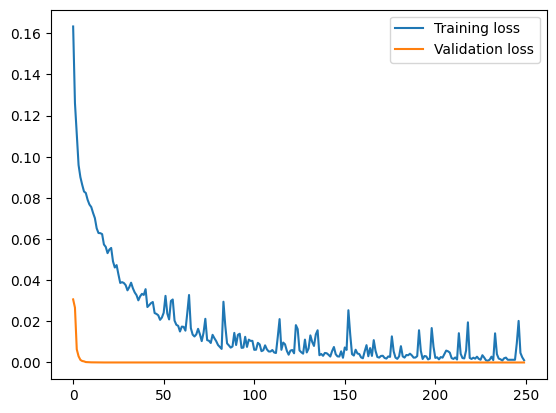

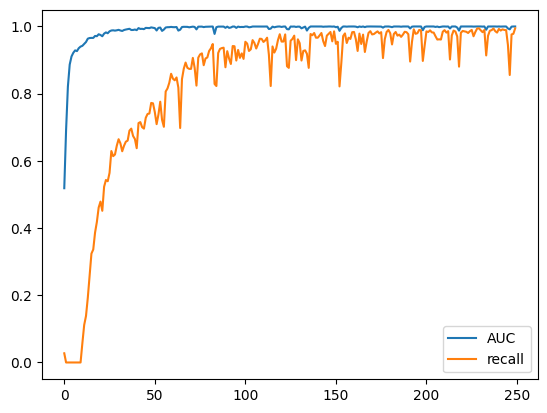

In [124]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show();
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['recall'], label='recall')
plt.legend()

In [132]:
PT_path

'Model/CNN2-LSTM'

In [134]:
model.load_weights(PT_path)

In [135]:
prediction_train=model.predict(trainX).mean(axis=1)
trainResults= pd.DataFrame()


388/388 [==============================] - 3s 9ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

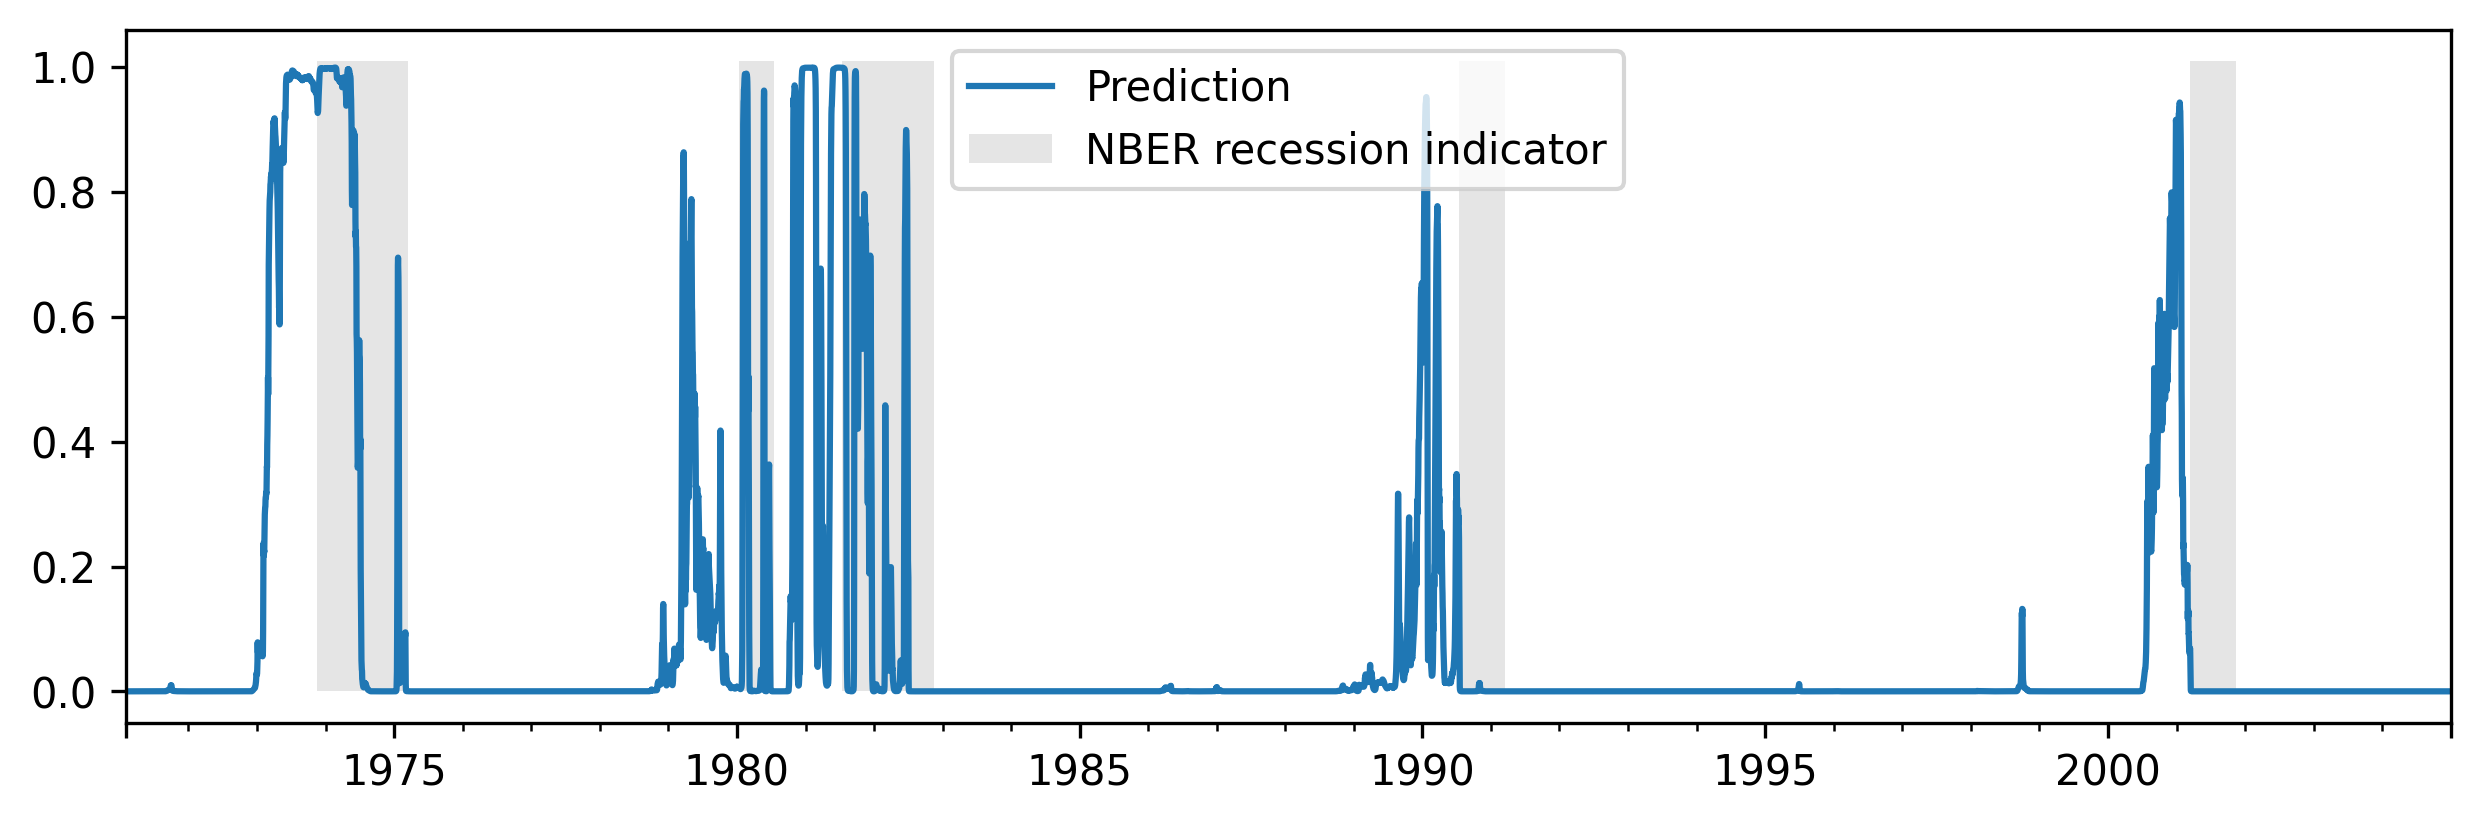

In [136]:
trainResults['Actual']=df_for_training.iloc[-prediction_train.shape[0]:,-2]
trainResults['Pred']=prediction_train
plot((trainResults['Pred']),df_for_training.iloc[-prediction_train.shape[0]:,-2])

In [137]:
prediction=model.predict(testX)
min_length = min(len(df_for_testing), len(prediction))
testResults = pd.DataFrame()


221/221 [==============================] - 2s 9ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

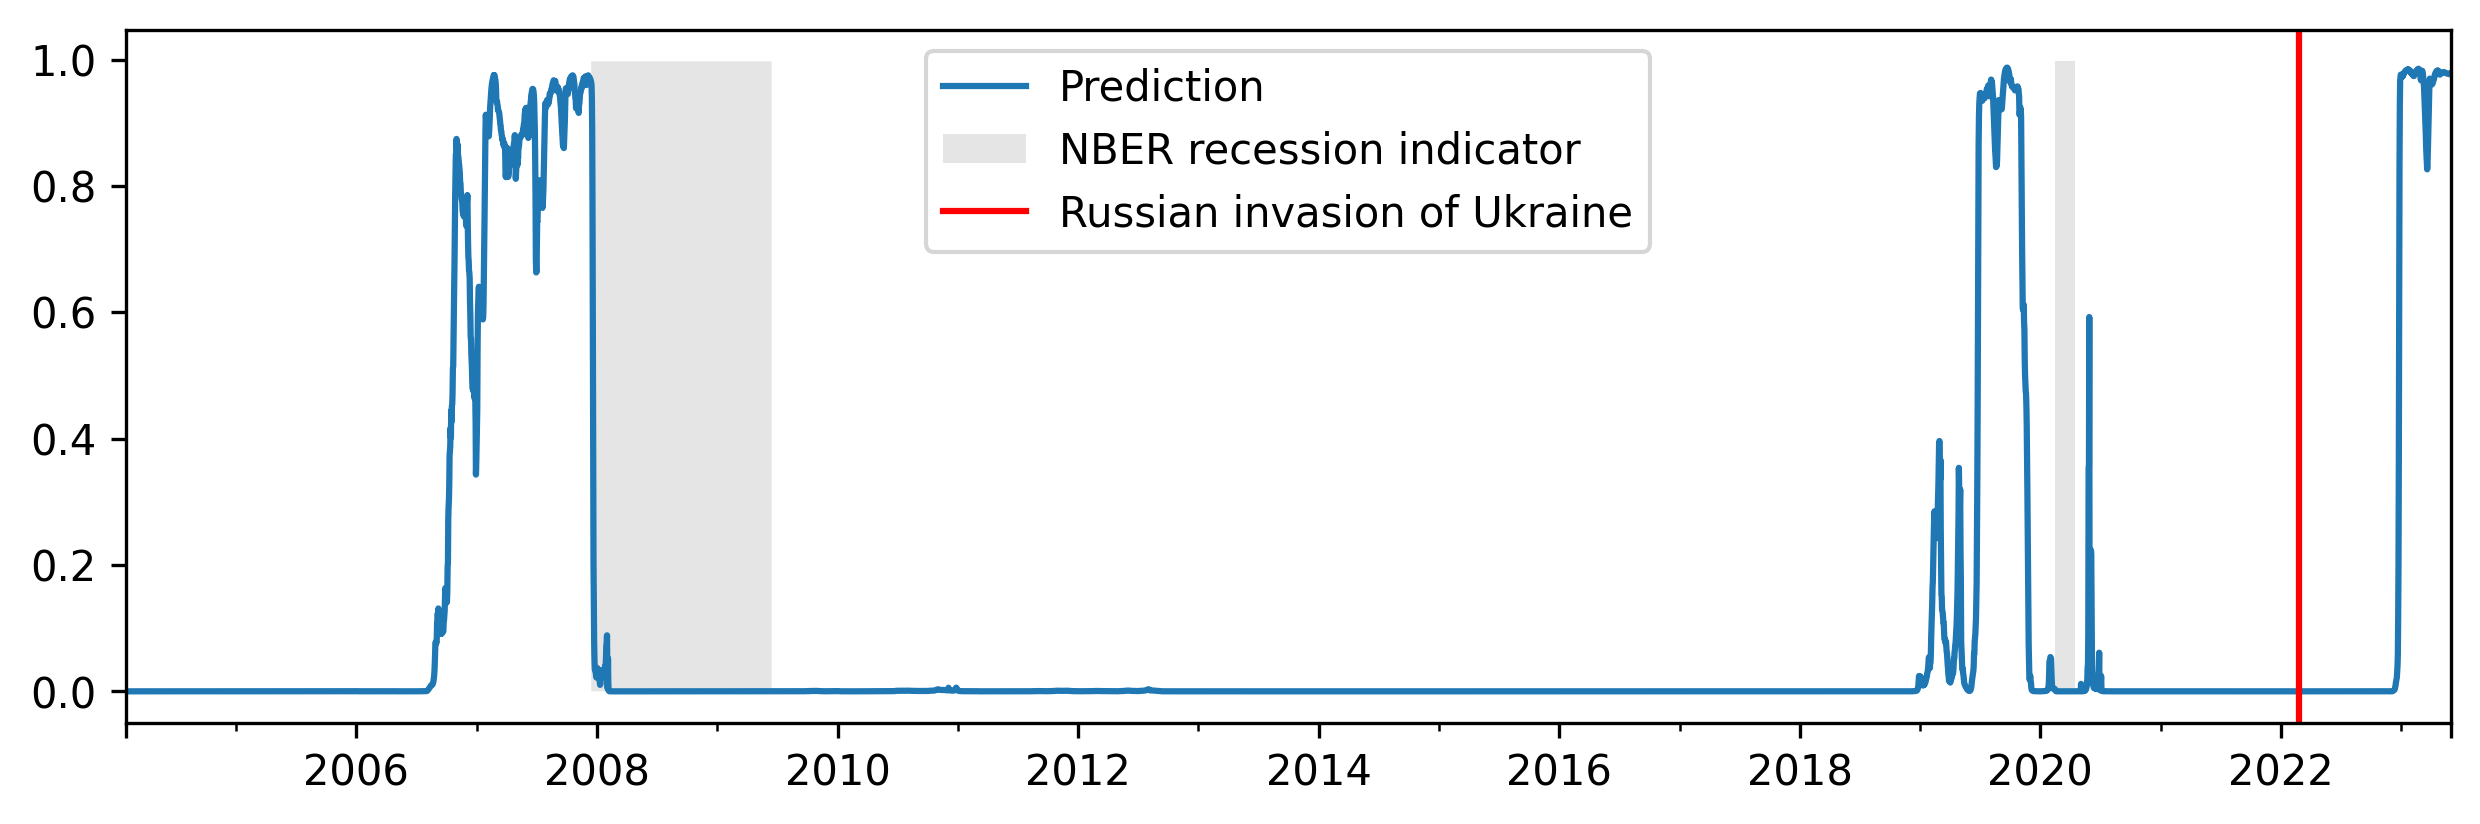

In [142]:
testResults['Actual']=df_for_testing.iloc[-min_length:, -2]
testResults["Pred"]=prediction[-min_length:]
plot((testResults['Pred']).rolling(1).mean(),testResults["Actual"])

In [139]:
'2004-01-02' in df_for_testing.index

True

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

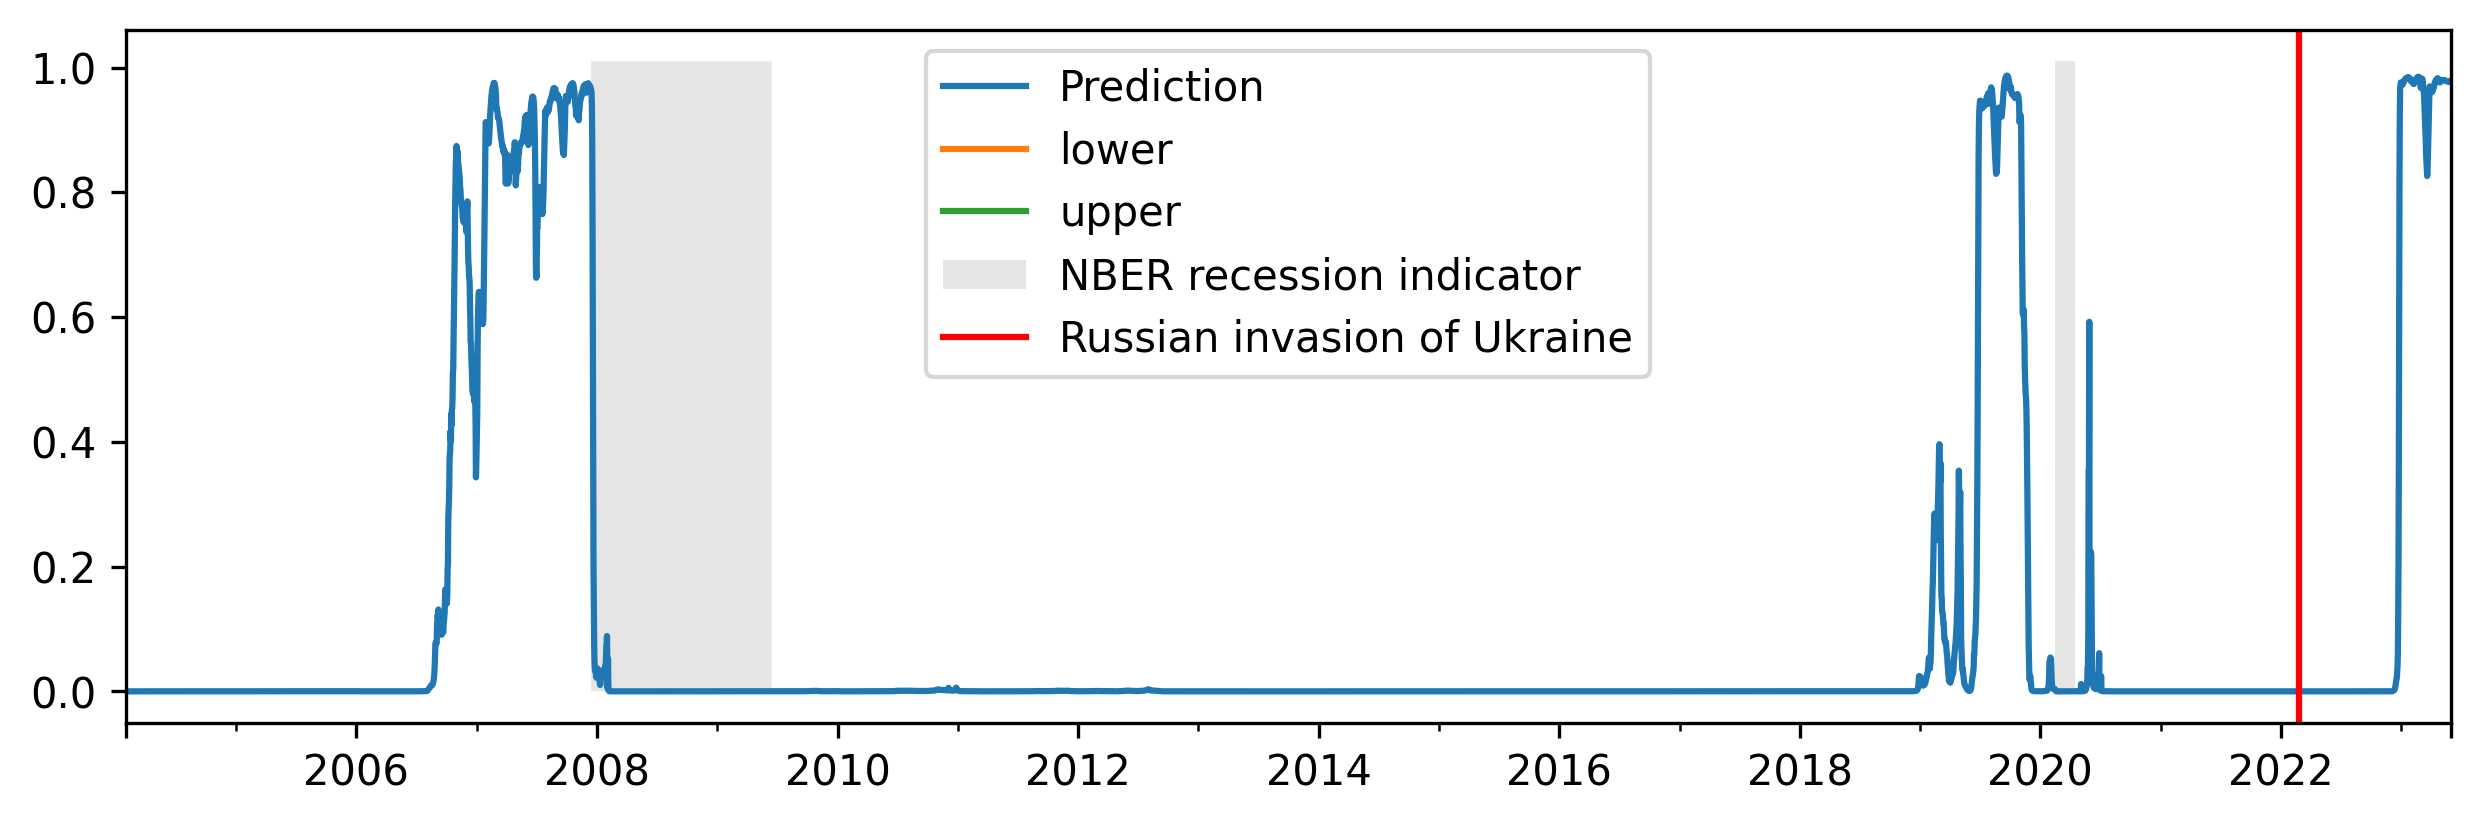

In [140]:

pred=prediction
origin=df_for_testing


min_length = min(len(origin), len(prediction))
pred=pred[-min_length:]
origin=origin.iloc[-min_length:, -2]

aligned = pd.DataFrame(columns=[f'pred{i}' for i in range(n_forecast)], index=pd.date_range(
    start=origin.index[0], freq='D', periods=pred.shape[0]+n_forecast-1))
for i in range(len(prediction)):
    col=i % n_forecast
    try:
        aligned.iloc[i:i+n_forecast,col]=prediction[i]
    except IndexError:
        break
CI=aligned.std(axis=1)* 1.96 / np.sqrt(aligned.shape[1])
mean=aligned.mean(axis=1)
aligned=pd.concat([mean,mean-CI,mean+CI],keys=['m','lc',"uc"],axis=1)
plot(aligned,testResults["Actual"])